### Gets Semantic Scholar ID for further processing
...based on the ARXIV ID or DOI

In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import Normalize
import json
import numpy as np
import pandas as pd
import requests
import warnings
import pickle
from sklearn.cluster import KMeans, DBSCAN
from scipy.optimize import curve_fit
import time
from tqdm import tqdm

In [2]:
#Load your api key
with open('api_keys.json') as f:
    api_keys = json.load(f)
key = api_keys['semantic_scholar']

In [3]:
def add_ids(data_w_ids, paper_idx, r):
    no_arxiv = False
    no_doi = False
    data_w_ids[paper_idx].update({'paperId': r['paperId']})
    try:
        data_w_ids[paper_idx].update({'arxivId': r['externalIds']['ArXiv']})
    except:
        no_arxiv = True
    try:
        data_w_ids[paper_idx].update({'DOI': r['externalIds']['DOI']})
    except:
        no_doi = True
    if no_doi and no_arxiv:
        print('No DOI AND No Arxiv found')
    return False

In [4]:
def new_get_values(data, payload=None):
    """get number of citations for all datasets by accessing the semantic scholar api
    number of citations are obtained by link of paper if it's an arxiv paper or alternatively by
    the papers DOI"""
    data_w_ids = data.copy()
    if payload is None:
        payload = {'fields': 'citationCount'}
    missing = []
    for paper_idx, paper in enumerate(tqdm(data)):
        searching = True
        if 'DOI' in paper.keys() and paper['DOI'] != '-' and searching:
            with requests.Session() as s:
                r = s.get(f'https://api.semanticscholar.org/graph/v1/paper/DOI:{paper["DOI"]}',headers={'x-api-key':key}, timeout=30,
                             params=payload).json()
                if 'error' not in r.keys():
                    searching = add_ids(data_w_ids, paper_idx, r)
                #else:
                    #print('failed doi', r)
        if searching and 'relatedPaper' in paper.keys() :
            if 'arxiv' or 'semanticscholar' in paper['relatedPaper']:
                url = (paper['relatedPaper'].replace('.pdf', ''))
                r = requests.get(f'https://api.semanticscholar.org/graph/v1/paper/URL:{url}',headers={'x-api-key':key}, timeout=30, params=payload).json()
                if 'error' not in r.keys():
                    #print('success!!!!', url)
                    searching = add_ids(data_w_ids, paper_idx, r)
        if searching:
            missing.append(paper['id'])
    else:
        print('Number of Missing Papers:', len(missing), '/', len(data))
    return data_w_ids, missing

In [5]:
file_name = 'data/data_sorted_new.json'
with open(file_name, "r", encoding='utf-8') as ds:
    data = json.load(ds)

In [6]:
payload = {'fields': 'paperId,externalIds'}
ids, missing_data = new_get_values(data, payload)
missing_data

100%|██████████| 211/211 [01:27<00:00,  2.40it/s]

Number of Missing Papers: 60 / 211


['WildDash 2',
 'PandaSet',
 'Udacity',
 'WZ-traffic dataset',
 'Nighttime Driving',
 'AIODrive',
 'Steet Hazards Dataset',
 'RoadObstacle21',
 'Astyx Dataset',
 'A Parametric Top-View Representation of Complex Road Scenes',
 'VITRO',
 'UDrive Dataset',
 'PolySync Dataset',
 'DriveSeg (MANUAL)',
 'DriveSeg (Semi-auto)',
 'KUL Belgium Traffic Sign dataset',
 'comma10k',
 'SemanticPOSS',
 'SemanticUSL',
 'ELEKTRA',
 'LUMPI',
 'Highway Work Zones',
 'NEXET',
 'RDD2020',
 'K-Lane',
 'Ithaca365',
 'TuSimple',
 'Astyx HiRes 2019',
 'Daimler Urban Segmentation',
 'Toronto City',
 'Raincouver',
 'CCSAD',
 'Cheddar Gorge Dataset',
 'The Annotated Laser Dataset',
 'DDD 17',
 'FLIR Thermal Dataset',
 'Multispectral Object Detection',
 'CityPersons',
 'ETH Pedestrian',
 'RoadSaW',
 'Daimler Pedestrian',
 'TTI Core',
 'TAF-BW',
 'Road Scene Graph',
 'EISATS',
 'Ford CAMPUS',
 'Argoverse Stereo',
 'uniD',
 'exiD',
 'Argoverse 2',
 'MuIRan',
 'PIE',
 'HAD',
 'HDBD',
 'HDD',
 'HEV-I',
 'HSD',
 'LOKI',

In [8]:
'''ids_pickle = 'ids.pckl'
with open(ids_pickle, 'rb') as f:
    ids = pickle.load(f)
ids'''

"ids_pickle = 'ids.pckl'\nwith open(ids_pickle, 'rb') as f:\n    ids = pickle.load(f)\nids"

In [13]:
def save_only_papers_w_ids():
    """Searches for the ids of papers and saves those which have ids"""
    file_name = 'data/data_sorted_new.json'
    with open(file_name, "r", encoding='utf-8') as ds:
        data = json.load(ds)
        payload = {'fields': 'paperId,externalIds'}
    ids, missing_data = new_get_values(data, payload)
    c = 0
    only_papers_w_ids = []
    for id in ids:
        if 'paperId' in id.keys():
            only_papers_w_ids.append(id)
            c+=1
    with open('data/data_sorted_only_w_ids.json', 'w', encoding='utf-8') as f:
        json.dump(only_papers_w_ids, f)

In [14]:
save_only_papers_w_ids()

100%|██████████| 216/216 [01:24<00:00,  2.57it/s]

Number of Missing Papers: 60 / 216


In [51]:
citations_r = r.json()
for citations in citations_r['data']:
    if citations['citingPaper']['year'] < 2022:
        print(citations)

{'citingPaper': {'paperId': '0282c031d07bf12d807392601371af86a56cce27', 'title': 'Active Learning for Domain Adaptation: An Energy-based Approach', 'year': 2021}}
{'citingPaper': {'paperId': '0314cfdc5fac4f9a9b9195c73dea9e4a1203b471', 'title': 'KITTI-360: A Novel Dataset and Benchmarks for Urban Scene Understanding in 2D and 3D', 'year': 2021}}
{'citingPaper': {'paperId': '0c66b951af3704962f68d3997119a82c5a3a1ddb', 'title': 'Enhancing Photorealism Enhancement', 'year': 2021}}
{'citingPaper': {'paperId': '0f3ed68552a315b5f563c2980efb3a8dfea84a25', 'title': 'An Overview of Facial Micro-Expression Analysis: Data, Methodology and Challenge', 'year': 2020}}
{'citingPaper': {'paperId': '1881b7f9ba3b014783c45afb0257cbf182ea3ebb', 'title': 'Maximizing Cosine Similarity Between Spatial Features for Unsupervised Domain Adaptation in Semantic Segmentation', 'year': 2021}}
{'citingPaper': {'paperId': '1d26f3d233181e5a1e2487371d9faf5be68eddfd', 'title': 'Uncertainty-Aware Consistency Regularization

In [62]:
paper = citations[1]
cummulative2ndlvl_citations = 0
ls_citations_citations = []
for citation in paper[-1]:
    paperId = citation['paperId']
    r = requests.get(f'https://api.semanticscholar.org/graph/v1/paper/{paperId}/?fields=year,citationCount,citations.year')
    citationCount = r.json()
    print(citationCount)
    ls_citations_citations.append(citationCount)
    cummulative2ndlvl_citations+= citationCount['citationCount']
print(cummulative2ndlvl_citations)

{'paperId': '9ccab6a6c431d18dba9018b1fd830f19c52278ac', 'year': 2022, 'citationCount': 0, 'citations': []}
{'paperId': '83046b6e648d6135334f65b6ee3a74b24f14d8fb', 'year': 2021, 'citationCount': 0, 'citations': []}
{'paperId': '0478dd159011ba1928768382d47a658f9e4e74a5', 'year': 2019, 'citationCount': 7, 'citations': [{'paperId': '1d45b31bdeeea4236c20448e67ee1f245ba5640b', 'year': 2022}, {'paperId': '0744f13ce6f492fc13647a502bdf8e2447711340', 'year': 2022}, {'paperId': '14b61cc046115db248c1b6474a3a15084dde9550', 'year': 2021}, {'paperId': '189d4806d90badda1eed07b3cbbe7cccfee1f599', 'year': 2022}, {'paperId': '70fc7e33fa2953c1314e7e22ecc80a7029a40355', 'year': 2021}, {'paperId': 'e80938d87ce086a3395778b50b4a5eae55e6e51d', 'year': 2021}, {'paperId': 'a0353f7560feb02b665d50dc50a25ff2c694c43e', 'year': 2020}]}
{'paperId': '974c0f466248007bd4580921d34dd0e783c3d9dc', 'year': 2020, 'citationCount': 0, 'citations': []}
{'paperId': 'd4efc93ce0bf4d8ba7560c5e1cc296c8d6ad2982', 'year': 2020, 'citati

In [63]:
'''init_publication = paper[2]
#'paper': [yr_of_1st_citation-init_pub_yr][(yr_o_2nd_citation_id1 - init_pub_yr)-(yr_o_2nd_citation_id1 - init_pub_yr)]
ls_out = []
for citing_paper in ls_citations_citations:
    
'''

[{'paperId': '9ccab6a6c431d18dba9018b1fd830f19c52278ac',
  'year': 2022,
  'citationCount': 0,
  'citations': []},
 {'paperId': '83046b6e648d6135334f65b6ee3a74b24f14d8fb',
  'year': 2021,
  'citationCount': 0,
  'citations': []},
 {'paperId': '0478dd159011ba1928768382d47a658f9e4e74a5',
  'year': 2019,
  'citationCount': 7,
  'citations': [{'paperId': '1d45b31bdeeea4236c20448e67ee1f245ba5640b',
    'year': 2022},
   {'paperId': '0744f13ce6f492fc13647a502bdf8e2447711340', 'year': 2022},
   {'paperId': '14b61cc046115db248c1b6474a3a15084dde9550', 'year': 2021},
   {'paperId': '189d4806d90badda1eed07b3cbbe7cccfee1f599', 'year': 2022},
   {'paperId': '70fc7e33fa2953c1314e7e22ecc80a7029a40355', 'year': 2021},
   {'paperId': 'e80938d87ce086a3395778b50b4a5eae55e6e51d', 'year': 2021},
   {'paperId': 'a0353f7560feb02b665d50dc50a25ff2c694c43e', 'year': 2020}]},
 {'paperId': '974c0f466248007bd4580921d34dd0e783c3d9dc',
  'year': 2020,
  'citationCount': 0,
  'citations': []},
 {'paperId': 'd4efc93ce

In [ ]:
cit_ref_df = pd.DataFrame(np.array(citations, dtype="object"), columns=['id', 'year', 'references', 'citations', 'influentialCitationCount'])
print(cit_ref_df)

In [ ]:
cit_ref_df

In [ ]:
cit_ref_df.to_csv('requests2.csv')

In [84]:
cit_ref_df = pd.read_csv('requests.csv')

In [91]:
cit_ref_df.year.mean()

2019.2380952380952

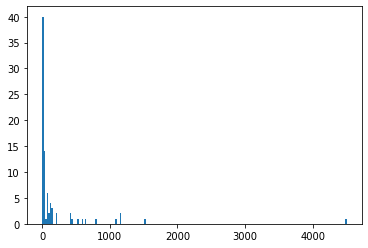

In [88]:
plt.hist(cit_ref_df.citations, bins=200)
plt.show()

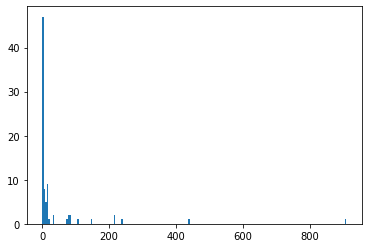

In [89]:
plt.hist(cit_ref_df.influentialCitationCount, bins=200)
plt.show()

In [ ]:
#distributions seems to be similar, just shifted to the left
#how big is the overlap?

Comparison of the papers w citation counts lower than the 80th percentile vs the ones above

In [ ]:
lessCited = cit_ref_df.loc[cit_ref_df.citations <= cit_ref_df.citations.quantile(0.8)]
lessCited.describe()

In [ ]:
oftenCited = cit_ref_df.loc[cit_ref_df.citations > cit_ref_df.citations.quantile(0.8)]
oftenCited.describe()

Learning: The most cited papers are 3 yrs younger, and reference 10 papers fewer (44 vs. 54)

In [ ]:
file_name = "data_sorted.json"
with open(file_name, "r") as ds:
    data = json.load(ds)

payload = {'fields': 'citations,year,citationCount,referenceCount,influentialCitationCount'}
payload = {'fields': 'year,citations.year'}
#citations = get_values(data, payload)
citations

In [ ]:
all_citations = citations

In [ ]:
citations = citations[:-12] #some have not been cited, so there are missing values, there has to be a more elegant way to do this

In [110]:
pckl_path = 'data/citations.pckl'

In [111]:
with open(pckl_path, 'wb') as f:
    pickle.dump(citations, f)

NameError: name 'citations' is not defined

In [112]:
with open(pckl_path, 'rb')as f:
    citations = pickle.load(f)
citations

EOFError: Ran out of input

In [81]:
def citation_year_counter(df):
    """returns list with [id, publication_year, [years in which the paper has been cited starting at 0], [how often it has been cited in the respective years]]"""
    all_paper_in_year = []
    for paper in df:
        cited_in_yr = []
        for citing_paper_year in paper[3]:
            cited_in_yr.append(citing_paper_year['year'])
        else:
            value_counted = []
            year_counted = []
            yrs = list(filter(None, (list(set(cited_in_yr)))))
            yrs.sort()
            print(cited_in_yr)
            for year in yrs:
                value_counted.append(cited_in_yr.count(year))
                year_counted.append(year-paper[2])
        all_paper_in_year.append([paper[0], paper[2], year_counted, value_counted])
    return all_paper_in_year

In [82]:
all_paper_in_year = citation_year_counter(citations)
all_paper_in_year

[2022, 2022, 2021, 2021, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2021, 2022, 2022, 2022, 2021, 2022, 2022, 2022, 2022, 2022, 2019, 2022, 2020, 2022, 2022, 2022, 2022, 2021, 2022, 2020, 2022, 2020, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2021, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2021, 2022, 2021, 2022, 2022, 2022, 2019, 2019, 2022, 2022, 2019, 2022, 2022, 2022, 2022, 2022, 2022, 2021, 2022, 2020, 2021, 2022, 2022, 2022, 2021, 2022, 2022, 2020, 2019, 2021, 2022, 2022, 2022, 2020, 2022, 2021, 2022, 2022, 2022, 2022, 2022, 2021, 2021, 2022, 2022, 2022, 2020, 2022, 2022, 2022, 2022, 2022, 2021, 2022, 2022, 2022, 2022, 2021, 2022, 2022, 2022, 2022, 2022, 2022, 2021, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2019, 2021, 2022, 2022, 2020, 2022, 2022, 2022, 2021, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2021, 2021, 2022, 2020, 2022, 2022, 2021, 2022, 2022, 2022, 2022, 2021, 2022, 2022, 2022, 2022, 202

[['KITTI',
  2013,
  [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
  [1, 6, 82, 171, 244, 364, 579, 861, 1017, 881, 296]],
 ['Cars Dataset',
  2013,
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
  [1, 9, 24, 52, 113, 160, 276, 382, 378, 117]],
 ['nuScenes', 2019, [-1, 0, 1, 2, 3], [5, 90, 378, 509, 194]],
 ['GTA5',
  2016,
  [-2, 0, 1, 2, 3, 4, 5, 6],
  [1, 22, 101, 173, 214, 250, 252, 78]],
 ['Oxford Robot Car',
  2017,
  [-2, -1, 0, 1, 2, 3, 4, 5],
  [2, 5, 46, 112, 158, 226, 187, 59]],
 ['Caltech Pedestrian',
  2009,
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
  [5, 47, 54, 43, 53, 52, 51, 45, 80, 77, 68, 40, 17, 1]],
 ['Beyond PASCAL',
  2014,
  [0, 1, 2, 3, 4, 5, 6, 7, 8],
  [11, 47, 53, 73, 120, 106, 95, 75, 20]],
 ['Waymo Open Perception', 2019, [-1, 0, 1, 2, 3], [1, 8, 148, 272, 107]],
 ['BDD100k', 2018, [-1, 0, 1, 2, 3, 4], [1, 11, 61, 71, 222, 69]],
 ['Argoverse Motion Forecasting',
  2019,
  [-1, 0, 1, 2, 3],
  [3, 33, 146, 170, 69]],
 ['Argoverse 3D Tracking', 2019, [-1, 0, 1, 2, 3], [3, 3

In [94]:
years = all_paper_in_year
for idx_paper, paper in enumerate(years):
    cumulated_citations = []
    for idx, citations in enumerate(paper[3]):
        print(sum(paper[3][:idx+1]))
        cumulated_citations.append(sum(paper[3][:idx+1]))
    else:
        years[idx_paper].append(cumulated_citations)
years


1
7
89
260
504
868
1447
2308
3325
4206
4502
1
10
34
86
199
359
635
1017
1395
1512
5
95
473
982
1176
1
23
124
297
511
761
1013
1091
2
7
53
165
323
549
736
795
5
52
106
149
202
254
305
350
430
507
575
615
632
633
11
58
111
184
304
410
505
580
600
1
9
157
429
536
1
12
73
144
366
435
3
36
182
352
421
3
36
182
352
421
19
63
158
215
223
10
40
105
183
214
1
16
65
129
149
2
25
68
103
127
136
2
25
68
103
127
136
6
54
109
126
1
5
47
109
128
2
18
51
98
122
7
29
48
64
78
110
121
2
19
51
88
104
17
49
82
97
12
41
73
87
2
16
45
76
82
2
20
40
68
79
8
53
74
8
53
74
1
22
60
71
1
5
9
22
34
52
62
7
16
37
45
1
11
36
44
2
28
40
2
28
40
2
7
20
34
39
21
34
1
16
27
32
33
3
15
27
29
1
4
12
21
28
2
8
21
26
1
19
25
2
13
21
25
9
15
23
24
7
19
23
1
4
14
23
8
21
4
3
10
13
17
20
4
10
18
21
14
19
9
16
4
11
8
13
5
12
1
8
11
4
6
7
8
4
7
8
1
9
1
5
6
1
4
2
4
1
4
1
3
2
2
1
1
1
1
1


[['KITTI',
  2013,
  [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
  [1, 6, 82, 171, 244, 364, 579, 861, 1017, 881, 296],
  [1, 7, 89, 260, 504, 868, 1447, 2308, 3325, 4206, 4502]],
 ['Cars Dataset',
  2013,
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
  [1, 9, 24, 52, 113, 160, 276, 382, 378, 117],
  [1, 10, 34, 86, 199, 359, 635, 1017, 1395, 1512]],
 ['nuScenes',
  2019,
  [-1, 0, 1, 2, 3],
  [5, 90, 378, 509, 194],
  [5, 95, 473, 982, 1176]],
 ['GTA5',
  2016,
  [-2, 0, 1, 2, 3, 4, 5, 6],
  [1, 22, 101, 173, 214, 250, 252, 78],
  [1, 23, 124, 297, 511, 761, 1013, 1091]],
 ['Oxford Robot Car',
  2017,
  [-2, -1, 0, 1, 2, 3, 4, 5],
  [2, 5, 46, 112, 158, 226, 187, 59],
  [2, 7, 53, 165, 323, 549, 736, 795]],
 ['Caltech Pedestrian',
  2009,
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
  [5, 47, 54, 43, 53, 52, 51, 45, 80, 77, 68, 40, 17, 1],
  [5, 52, 106, 149, 202, 254, 305, 350, 430, 507, 575, 615, 632, 633]],
 ['Beyond PASCAL',
  2014,
  [0, 1, 2, 3, 4, 5, 6, 7, 8],
  [11, 47, 53, 73, 120, 106, 95,

In [95]:
df_year_of_citation = pd.DataFrame(np.array(all_paper_in_year, dtype="object"), columns=['id', 'year', 'year_of_citation', 'number_of_c_in_yr', 'cumulated_citations'])
df_year_of_citation.year_of_citation = pd.Series(df_year_of_citation.year_of_citation)
df_year_of_citation

,id,year,year_of_citation,number_of_c_in_yr,cumulated_citations
0,KITTI,2013,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[1, 6, 82, 171, 244, 364, 579, 861, 1017, 881,...","[1, 7, 89, 260, 504, 868, 1447, 2308, 3325, 42..."
1,Cars Dataset,2013,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[1, 9, 24, 52, 113, 160, 276, 382, 378, 117]","[1, 10, 34, 86, 199, 359, 635, 1017, 1395, 1512]"
2,nuScenes,2019,"[-1, 0, 1, 2, 3]","[5, 90, 378, 509, 194]","[5, 95, 473, 982, 1176]"
3,GTA5,2016,"[-2, 0, 1, 2, 3, 4, 5, 6]","[1, 22, 101, 173, 214, 250, 252, 78]","[1, 23, 124, 297, 511, 761, 1013, 1091]"
4,Oxford Robot Car,2017,"[-2, -1, 0, 1, 2, 3, 4, 5]","[2, 5, 46, 112, 158, 226, 187, 59]","[2, 7, 53, 165, 323, 549, 736, 795]"
...,...,...,...,...,...
64,DRIV100,2021,[1],[1],[1]
65,MIT-AVT Clustered Driving Scene Dataset,2020,[1],[1],[1]
66,SODA10M,2021,[1],[1],[1]
67,Boreas,2022,[0],[1],[1]


GTA5 and Oxford Robot Car are the ones that have citations at -2 years.

In [97]:
ap = []
for paper in all_paper_in_year:
    print(paper[1])
    #if paper[1] < 2022 and (sum(paper[3]) > 10):
    ap.append(paper)
all_paper_in_year = ap
print(len(all_paper_in_year))

2013
2013
2019
2016
2017
2009
2014
2019
2018
2019
2019
2018
2018
2019
2017
2017
2019
2019
2018
2015
2018
2019
2019
2018
2018
2020
2020
2020
2016
2019
2020
2020
2020
2018
2021
2018
2019
2018
2019
2020
2019
2018
2020
2020
2021
2019
2018
2019
2020
2020
2020
2021
2021
2020
2019
2019
2021
2020
2020
2021
2020
2021
2022
2022
2021
2020
2021
2022
2021
69


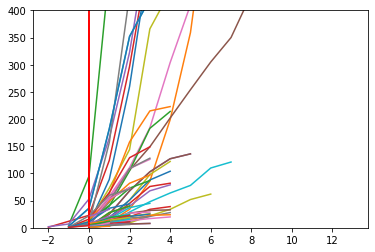

In [98]:
plt.clf()
for paper in all_paper_in_year:
    plt.plot(paper[2], paper[4])
    plt.vlines(0, 0, max(paper[3]), colors='red')
    plt.ylim(0, 400)
plt.show()

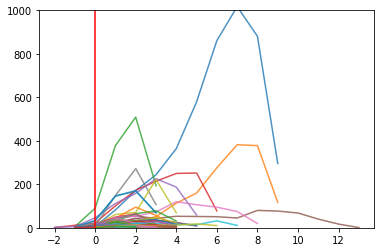

In [12]:
for paper in all_paper_in_year:
    plt.plot(paper[2], paper[3], alpha=0.8)
y_lim = 1000
plt.ylim(0, y_lim)#
plt.vlines(0, 0, y_lim, colors='red')
plt.show()

clustering useful?

Why do data sets reach their peaks? And when do they reach it? Why do ppl stop using them?

In [99]:
def citation_year_counter_kmeans(data):
    '''returns list with [id, publication_year, [years in which the paper has been cited starting at 0], [how often it has been cited in the respective years]]'''
    all_paper_in_year = []
    min = 0
    max = 0
    for paper in data:
        n_min = np.min(paper[2])
        n_max = np.max(paper[2])
        if n_min < min:
            min = n_min
        if n_max > max:
            max = n_max
    length = 1 + abs(min) + max
    array = np.zeros([len(data), length])
    for paper_idx, paper in enumerate(range(array.shape[0])):
        for year_idx, year in enumerate(range(min, (max+1), 1)):
            if year in data[paper][2]: # year is in our data
                index_of_year = data[paper][2].index(year)
                array[paper_idx, year_idx] = data[paper][4][index_of_year]
    return array

clustering_array = citation_year_counter_kmeans(all_paper_in_year)
clustering_array

array([[ 0.,  1.,  7., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  5., 95., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [116]:
n = np.delete(clustering_array, np.s_[-8:], axis=1)
print(n.shape)
for year in range(n.shape[1]):
    print(np.mean(n[:][year]), np.std(n[:][year]), year)

(69, 8)
397.0 489.3807311286377 0
86.125 121.34397131707863 1
341.375 453.84246647377546 2
341.25 360.36674027995423 3
328.75 305.148631817349 4
96.0 92.03124469439713 5
134.75 143.57815815784795 6
141.5 204.90546600810825 7


In [15]:
def linear_fit(x, a, b):
    return (a*x+b)
def extrapolate(idcs, values):
    #l = np.array([0, 1, 2])
    #m = np.array([2, 4, 6])
    params, covariance = curve_fit(linear_fit, idcs, values)
    a, b = params
    print(a, b)
    next = idcs.shape[0]+1
    return linear_fit(next, a, b)

In [16]:
data = n
for row_idx, row in enumerate(data):
    for idx, value in enumerate(row):
        if value == 0 and idx > 3:
            print(row)
            row_values = np.array(row[2:idx])
            row_idcs = np.array([*range(0, row_values.shape[0])])
            data[row_idx][idx] = (round(extrapolate(row_idcs, row_values)))
data

[   0.    5.   95.  473.  982. 1176.    0.    0.]
375.19999965863593 118.70000218208754
[   0.    5.   95.  473.  982. 1176. 1995.    0.]
450.2999989339098 43.600001270717655
[  0.   1.   9. 157. 429. 536.   0.   0.]
185.29999953317397 4.800000564121703
[  0.   1.   9. 157. 429. 536. 931.   0.]
222.3000004282125 -32.20000117155216
[  0.   1.  12.  73. 144. 366. 435.   0.]
113.90000000024624 -21.800000000049625
[  0.   3.  36. 182. 352. 421.   0.   0.]
132.4999997839636 49.000000504084966
[  0.   3.  36. 182. 352. 421. 711.   0.]
158.89999997937377 22.600000610583663
[  0.   3.  36. 182. 352. 421.   0.   0.]
132.4999997839636 49.000000504084966
[  0.   3.  36. 182. 352. 421. 711.   0.]
158.89999997937377 22.600000610583663
[  0.   0.  19.  63. 158. 215. 223.   0.]
56.000000000119954 23.600000000049306
[  0.   0.  10.  40. 105. 183. 214.   0.]
55.100000000117994 0.1999999999983152
[  0.   1.  16.  65. 129. 149.   0.   0.]
46.300000000098805 20.30000000004209
[  0.   1.  16.  65. 129. 149

c:\users\jonas\pycharmprojects\datasets\venv\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


array([[0.000e+00, 1.000e+00, 7.000e+00, 8.900e+01, 2.600e+02, 5.040e+02,
        8.680e+02, 1.447e+03],
       [0.000e+00, 0.000e+00, 1.000e+00, 1.000e+01, 3.400e+01, 8.600e+01,
        1.990e+02, 3.590e+02],
       [0.000e+00, 5.000e+00, 9.500e+01, 4.730e+02, 9.820e+02, 1.176e+03,
        1.995e+03, 2.745e+03],
       [1.000e+00, 0.000e+00, 2.300e+01, 1.240e+02, 2.970e+02, 5.110e+02,
        7.610e+02, 1.013e+03],
       [2.000e+00, 7.000e+00, 5.300e+01, 1.650e+02, 3.230e+02, 5.490e+02,
        7.360e+02, 7.950e+02],
       [0.000e+00, 0.000e+00, 5.000e+00, 5.200e+01, 1.060e+02, 1.490e+02,
        2.020e+02, 2.540e+02],
       [0.000e+00, 0.000e+00, 1.100e+01, 5.800e+01, 1.110e+02, 1.840e+02,
        3.040e+02, 4.100e+02],
       [0.000e+00, 1.000e+00, 9.000e+00, 1.570e+02, 4.290e+02, 5.360e+02,
        9.310e+02, 1.302e+03],
       [0.000e+00, 1.000e+00, 1.200e+01, 7.300e+01, 1.440e+02, 3.660e+02,
        4.350e+02, 6.620e+02],
       [0.000e+00, 3.000e+00, 3.600e+01, 1.820e+02, 3.5

In [17]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(n)

In [18]:
clusters = kmeans.cluster_centers_

In [19]:
type(clusters)

numpy.ndarray

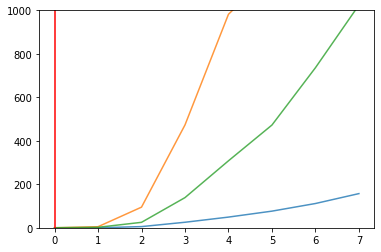

In [20]:
for cluster in clusters:
    plt.plot(cluster, alpha=0.8)
y_lim = 1000
plt.ylim(0, y_lim)#
plt.vlines(0, 0, y_lim, colors='red')
plt.show()

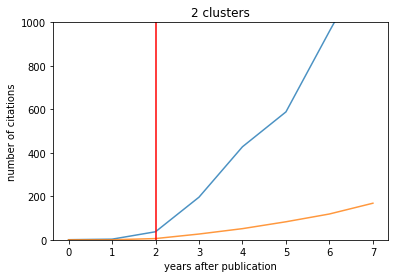

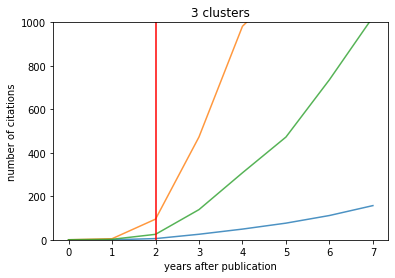

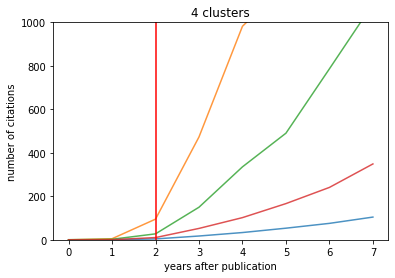

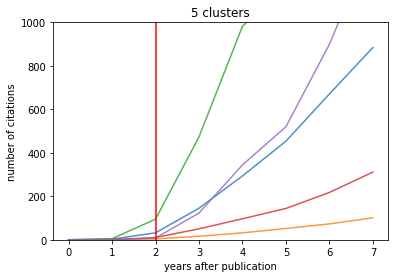

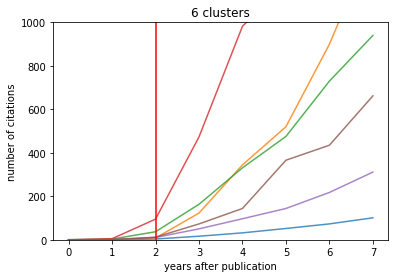

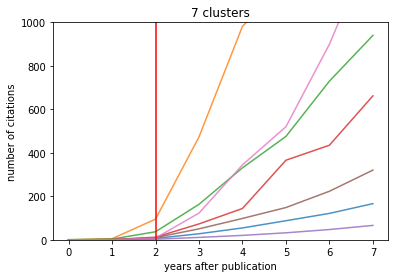

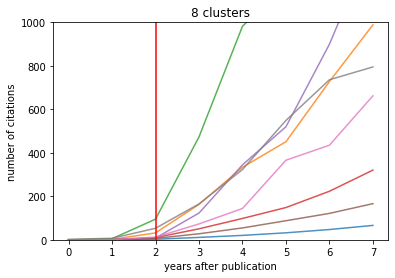

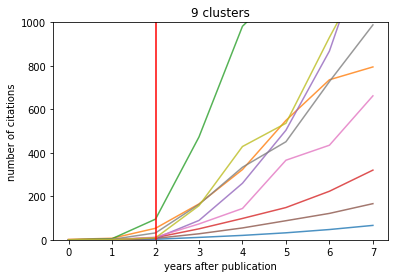

In [21]:
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(n)
    clusters = kmeans.cluster_centers_
    for cluster in clusters:
        plt.plot(cluster, alpha=0.8)
    y_lim = 1000
    plt.ylim(0, y_lim)#
    plt.vlines(2, 0, y_lim, colors='red')
    plt.title(f'{k} clusters')
    plt.xlabel('years after publication')
    plt.ylabel('number of citations')
    plt.show()

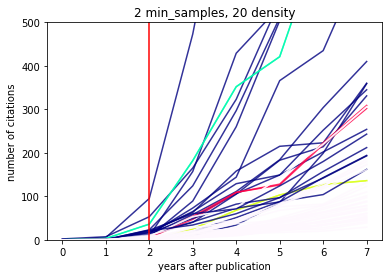

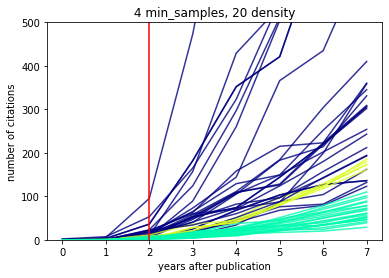

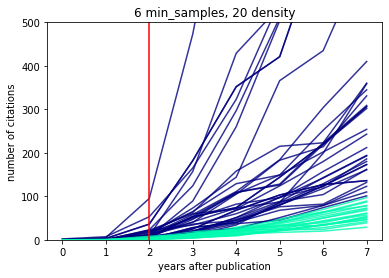

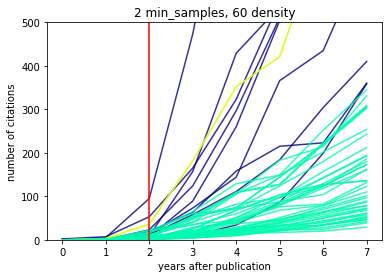

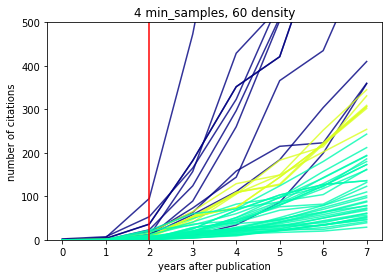

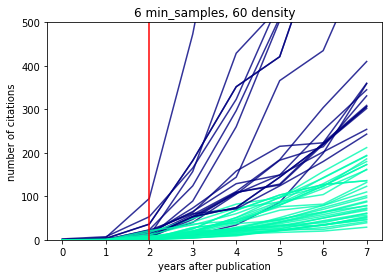

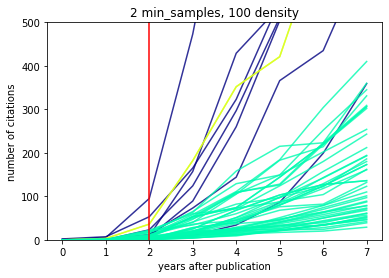

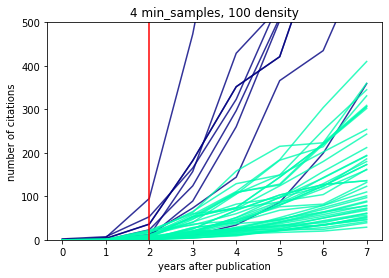

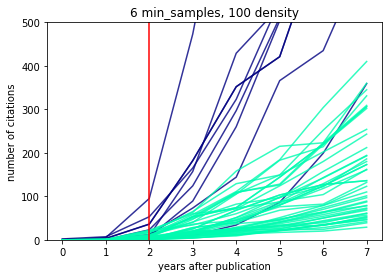

In [22]:
k = 25
for k in range(20, 101, 40):
    for s in range(2, 8, 2):
        dbscan = DBSCAN(eps=k, min_samples=s).fit(n)
        labels = dbscan.labels_
        cmap = colors.Colormap(set(dbscan.labels_))
        cmap = plt.cm.gist_ncar
        norm = Normalize(vmin=-1, vmax=3)
        for idx, cluster in enumerate(n):
            plt.plot(cluster, alpha=0.8, color=cmap(norm(labels[idx])))
        y_lim = 500
        plt.ylim(0, y_lim)#
        plt.vlines(2, 0, y_lim, colors='red')
        plt.title(f'{s} min_samples, {k} density')
        plt.xlabel('years after publication')
        plt.ylabel('number of citations')
        plt.show()

In [51]:
set(dbscan.labels_)

{-1, 0}

In [52]:
dbscan

DBSCAN(eps=100, min_samples=6)